In [1]:
#@title
import numpy as np
import pandas as pd
import threading
import time
from psutil import cpu_percent
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy as sp
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy import io
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist, cdist, squareform
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from tsfresh.feature_extraction import extract_features, ComprehensiveFCParameters
import os
%matplotlib inline

# .Recovery

In [2]:
def Recovery (DataName):
    
    #Changing Work Folder
    
    add_path1 = "/PCA_Analyses/";
    add_path2 = "/.Kernel/";
    add_path3 = "/.Recovery/";
    base_path = os.path.dirname(os.path.abspath("Model_Unified_Code.ipynb"));
    PCA_Analyses_path = base_path + add_path1;
    Kernel_path = base_path + add_path2;
    Recovery_path = base_path + add_path3;
     
    
    if DataName == 'D_S_parameters':
        
        # Now change to Kernel directory
    
        os.chdir( Kernel_path );
        
        Final_Target = np.genfromtxt('FinalTarget.csv', delimiter = ',')
        
        # Now change to Recovery directory
    
        os.chdir( Recovery_path );
        
        P_N_groups = int(np.load('M_N_groups.npy'))
        Output_Id = int(np.load('ID.npy'))
        P_N_Ids = int(np.load('N_IDs.npy'))
        
        # Now change to base directory
    
        os.chdir( base_path );
        
        Output = {'FinalTarget': Final_Target,
                  'M_N_groups': P_N_groups,
                  'ID': Output_Id,
                  'N_IDs': P_N_Ids}
        
        #retval = os.getcwd()
        #print ("Final working directory %s" % retval)
        
        return Output
    
    elif DataName == 'ExtractedNames':
        
        # Now change to Recovery directory
    
        os.chdir( Recovery_path );
        
        extracted_names = np.load('extracted_names.npy')
        
        # Now change to base directory
    
        os.chdir( base_path );
        
        #retval = os.getcwd()
        #print ("Final working directory %s" % retval)
    
        return extracted_names
    
    elif DataName == 'SelectedFeatures':
        
        # Now change to Recovery directory
    
        os.chdir( Recovery_path );
        
        Output_Id = int(np.load('ID.npy'))
        
        # Now change to Kernel directory
    
        os.chdir( Kernel_path );
        
        features_filtered_1 = pd.read_csv('features_filtered_' + str(Output_Id) + '.csv') 
        
        # Now change to base directory
    
        os.chdir( base_path );
        
        Output = {'FeaturesFiltered': features_filtered_1,
                  'ID': Output_Id}
        
        #retval = os.getcwd()
        #print ("Final working directory %s" % retval)
        
        return Output
        
    elif DataName == 'ReducedFeatures':
        
        # Now change to Recovery directory
    
        os.chdir( Recovery_path );
        
        Output_Id = int(np.load('ID.npy'))
        
        # Now change to PCA Analyses directory
    
        os.chdir( PCA_Analyses_path );
        
        features_reduzidas = np.genfromtxt("features_reduzidas_" + str(Output_Id) + ".csv", delimiter=',')
        
        # Now change to base directory
    
        os.chdir( base_path );
        
        Output = {'ReducedFeatures': features_reduzidas,
                  'ID': Output_Id}
        
        #retval = os.getcwd()
        #print ("Final working directory %s" % retval)
        
        return Output
        
    elif DataName == 'SODA_parameters_processing_parameters':
        
        Output_Id = int(np.load('ID.npy'))
        processing_parameters = np.genfromtxt('processing_parameters.csv',delimiter = ',')
        distances = np.genfromtxt('Distances.csv',delimiter = ',')
        min_granularity = np.genfromtxt('Min_g.csv',delimiter = ',')
        max_granularity = np.genfromtxt('Max_g.csv',delimiter = ',')
        pace = np.genfromtxt('Pace.csv',delimiter = ',')
    
        Output = {'Distances': distances,
                  'Min_g': min_granularity,
                  'Max_g': max_granularity,
                  'Pace': pace,
                  'ID': DataSetID}
    
        return Output, processing_parameters
        
    elif DataName == 'ClassificationPar':
        
        Output_Id = int(np.load('ID.npy'))
        distances = np.genfromtxt('Distances.csv',delimiter = ',')
        define_percent = np.genfromtxt('Percent.csv',delimiter = ',')
    
        Output = {'Percent': define_percent,
                  'Distances': distances,
                  'ID': DataSetID}
        return Output
        
    else:
        print("Wrong name lad/lass, please check de Recovery input")
    
    


In [3]:
#Using Recovery Function

#D_S_parameters = Recovery('D_S_parameters');
#ExtractedNames = Recovery('ExtractedNames');
#SelectedFeatures = Recovery('SelectedFeatures');
#ReducedFeatures = Recovery('ReducedFeatures');


# .Normalization:

In [4]:
def scale(X, x_min, x_max):
    nom = (X-X.min(axis=0))*(x_max-x_min)
    denom = X.max(axis=0) - X.min(axis=0)
    if denom==0:
        denom = 1
    return x_min + nom/denom

# .Plot Formater:

In [5]:
def format_func(value, tick_number):
    # find number of multiples of pi/2
    N = int(value)
    if N == 0:
        return "X1"
    elif N == 50:
        return "X50"
    elif N == 100:
        return "X100"
    elif N == 150:
        return "X150"
    elif N == 200:
        return "X200"
    elif N == 250:
        return "X250"

# Feature Extraction/Selection Module
    .Data Slicer for saving RAM;
    .TSFRESH feature extraction and selection;
    .PCA dimensionality reduction


# . Data Slicer:

In [6]:
def DataSlicer (Output_Id, id_per_group, Choice):
    
    print('Data Slicer Control Output') 
    print('----------------------------------')
    
    #Changing Work Folder
    
    add_path1 = "/Input/" 
    add_path2 = "/.Kernel/" 
    add_path3 = "/.Recovery/" 
    base_path = os.path.dirname(os.path.abspath("Model_Unified_Code.ipynb")) 
    Input_path = base_path + add_path1 
    Kernel_path = base_path + add_path2 
    Recovery_path = base_path + add_path3 
     
    # Now change to Input directory
    
    os.chdir( Input_path ) 
    
    # Loading the required input 
    
    Full_data = np.genfromtxt('Output_' + str(int(Output_Id)) + '.csv', delimiter=',') 
    #E_data = np.genfromtxt('Eminence_Data_' + str(Output_Id) + '.csv', delimiter=',') 
    rows, columns = Full_data.shape
    P_data = Full_data[:,0:columns-1] 
    Target = Full_data[:,columns-1] 

    print('Full Matrix: ' + str(Full_data.shape)) 
    print('Main Data: ' + str(P_data.shape)) 
    print('Labels: ' + str(Target.shape)) 
    #print('Eminence Data: ' + str(E_data.shape)) 
    
    # Now change to Kernel directory
          
    os.chdir( Kernel_path )

    ###______________________________________________________________________###
    ###                     ProDiMes Slicing Parameters                      ###


    P_N_Ids = int(np.amax(P_data,axis=0)[0]) 
    P_N_voos = int(np.amax(P_data,axis=0)[1]) 
    P_last_group = int(P_N_Ids % id_per_group) 

    if P_last_group != 0:
        P_N_groups = int((P_N_Ids / id_per_group) + 1) 
    else:
        P_N_groups = int (P_N_Ids / id_per_group) 

    print ('Main data Number of Ids: ' + str(P_N_Ids )) 
    print ('Main data Number of mesures: ' + str(P_N_voos )) 
    print ('Main data Number of groups: ' + str(P_N_groups )) 
    print ('Main data Last group: ' + str(P_last_group )) 
    print ('___________________________________________')

    ###______________________________________________________________________###
    ###                    Eminences Slicing Parameters                      ###

    #E_N_Ids = int(np.amax(E_data,axis=0)[0] - np.amax(P_data,axis=0)[0]) 
    #E_N_voos = int(np.amax(E_data,axis=0)[1]) + 1 
    #E_last_group = int(E_N_Ids % id_per_group) 

    #if (E_last_group != 0):
    #    E_N_groups = int((E_N_Ids / id_per_group) + 1) 
    #else:
    #    E_N_groups = int (E_N_Ids / id_per_group) 

    #print ('Eminences Number of Ids: ' + str(E_N_Ids )) 
    #print ('Eminences Number of flights: ' + str(E_N_voos )) 
    #print ('Eminences Number of groups: ' + str(E_N_groups )) 
    #print ('Eminences Last group: ' + str(E_last_group )) 


    ### Formating Final Target ###

    Final_Target = np.zeros((P_N_Ids)) 

    for i in range (P_N_Ids):

        Final_Target[i] = Target [i*P_N_voos] 
        
    #np.savetxt(('Target_' + str(int(Output_Id)) + '.csv'), Final_Target, delimiter = ',') 
    
    
    ###______________________________________________________________________###
    ###                      Slicing Prodimes Data                           ###

    if (Choice =='Main Data') or (Choice =='All'):
    
        for i in range (P_N_groups):                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
        
            Data = np.zeros(((id_per_group * P_N_voos),columns-1)) 
        
            for j in range (id_per_group):
            
                for k in range (P_N_voos):
            
                    if (i  < (P_N_groups - 1)):
                        Data[(j * P_N_voos) + k,:] = P_data [(((i * id_per_group + j) * P_N_voos) + k ) ,:] 

                    elif (P_last_group == 0) and (i == (P_N_groups - 1)):
                        Data[(j * P_N_voos) + k,:] = P_data [(((i * id_per_group + j) * P_N_voos) + k ) ,:] 
            
            if (P_last_group != 0) and (i == (P_N_groups - 1)):     

                Data = np.zeros(((P_last_group * P_N_voos),columns-1)) 
            
                for j in range (P_last_group):
    
                    for k in range (P_N_voos):
    
                        Data[(j * P_N_voos) + k,:] = P_data [(((i * id_per_group + j) * P_N_voos) + k ) ,:] 
        
            np.savetxt(('Data_' + str(i) + '.csv'), Data, delimiter = ',') 
    
    ###______________________________________________________________________###
    ###                          Slicing Eminences                           ###

    if (Choice == 'Eminence Data') or (Choice =='All'):
    
        for i in range (E_N_groups):                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
        
            Data = np.zeros(((id_per_group * E_N_voos),columns-3)) 
        
            for j in range (id_per_group):
            
                for k in range (E_N_voos):
            
                    if (i  < (E_N_groups - 1)):
                        Data[(j * E_N_voos) + k,:] = E_data [(((i * id_per_group + j) * E_N_voos) + k ) ,:] 
                
        
            if (E_last_group != 0) and (i == (E_N_groups - 1)):
            
                Data = np.zeros(((E_last_group * E_N_voos),columns-3)) 
            
                for j in range (E_last_group):
    
                    for k in range (E_N_voos):
    
                        Data[(j * E_N_voos) + k,:] = E_data [(((i * id_per_group + j) * E_N_voos) + k ) ,:] 
    
    
            np.savetxt(('Eminence_' + str(i) + '.csv'), Data, delimiter = ',') 
    
    
    np.savetxt(('FinalTarget.csv'), Final_Target, delimiter = ',') 
    
    # Now change to Recovery directory
          
    os.chdir( Recovery_path )
    
    np.save(('M_N_groups.npy'), P_N_groups)
    np.save(('ID.npy'), Output_Id) 
    np.save(('N_IDs.npy'), P_N_Ids) 
    
    # Now change back to Base directory
          
    os.chdir( base_path )
    
    Output = {'FinalTarget': Final_Target,
              'M_N_groups': P_N_groups,
              'ID': Output_Id,
              'N_IDs': P_N_Ids}
    
    return Output
    

# .TSFRESH:

In [7]:
def TSFRESH_Extraction(D_S_parameters):
    
    print('             ') 
    print('TSFRESH Control Output') 
    print('----------------------------------') 
    
    #Changing Work Folder
    
    add_path2 = "/.Kernel/" 
    add_path3 = "/.Recovery/" 
    base_path = os.path.dirname(os.path.abspath("Model_Unified_Code.ipynb")) 
    Kernel_path = base_path + add_path2 
    Recovery_path = base_path + add_path3 
        
    # Now change to Kernel directory
    
    os.chdir( Kernel_path ) 
    
    ###______________________________________________________________________###
    ###                         Feature Extraction                          ###

    #E_N_groups = np.load('E_N_groups.npy') 
    P_N_groups = D_S_parameters['M_N_groups'] 
    
    for i in range(P_N_groups):
        
        Data = np.genfromtxt('Data_' + str(i) + '.csv', delimiter=',') 
        data = pd.DataFrame(Data, columns= ['id','time'] + ['Sensor_' + str(x) for x in range(1,(Data.shape[1]-1))]) 
        
        Data_extracted_features = extract_features(data,column_id = "id", column_sort="time") 
        extracted_names = list(Data_extracted_features.columns) 
        np.savetxt('Data_Features_' + str(i) + '.csv', Data_extracted_features, delimiter=',') 
        
    #for i in range(E_N_groups):

    
    #    data = pd.DataFrame(np.genfromtxt('Eminence_' + str(i) + '.csv', delimiter=','), 
    #                        columns= ['id','time','sensor_1','sensor_2','sensor_3','sensor_4',
    #                                            'sensor_5','sensor_6','sensor_7']) 
    #    extracted_features = extract_features(data, column_id = "id", column_sort="time") 
    #    np.savetxt('Eminence_Features_' + str(i) + '.csv', extracted_features, delimiter=',') 
    
    # Now change to Recovery directory
    
    os.chdir( Recovery_path ) 
    
    np.save('extracted_names.npy',extracted_names)
    
    # Now change back to base directory
    
    os.chdir( base_path ) 
    
    return extracted_names

In [8]:
def TSFRESH_Selection(D_S_parameters,extracted_names):   
    ###______________________________________________________________________###
    ###                          Feature Selection                           ###
    
    P_N_groups = D_S_parameters['M_N_groups'] 
    Output_Id = D_S_parameters['ID'] 
    y = D_S_parameters['FinalTarget'] 
    
    #Changing Work Folder
    
    add_path2 = "/.Kernel/" 
    base_path = os.path.dirname(os.path.abspath("Model_Unified_Code.ipynb")) 
    Kernel_path = base_path + add_path2 
        
    # Now change back to Kernel directory
    
    os.chdir( Kernel_path ) 
    
    Data_Matrix = np.genfromtxt('Data_Features_0.csv', delimiter=',') 
    print('Data_Features_0.csv')
    print(np.shape(Data_Matrix))

    for i in range(1,P_N_groups):
    
        new_data = np.genfromtxt('Data_Features_' + str(i) + '.csv', delimiter=',')  
        
        print('Data_Features_' + str(i) + '.csv')
        print(np.shape(new_data))
    
        Data_Matrix = np.concatenate((Data_Matrix, new_data), axis=0) 

    
    #for i in range(E_N_groups):
    
    #    new_data = np.genfromtxt('Eminence_Features_' + str(i) + '.csv', delimiter=',')  
    
    #    Data_Matrix = np.concatenate((Data_Matrix, new_data), axis=0) 
    
    #    print('Eminence_Features_' + str(i) + '.csv')
    
    features = pd.DataFrame(Data_Matrix, columns= extracted_names) 
    
    impute(features)
    features_filtered_1 = select_features(features, y)
    features_filtered_1.sort_index(inplace = True)
    
    features_filtered_1.to_csv('features_filtered_' + str(Output_Id) + '.csv', index=False)
    
    # Now change back to base directory
    
    os.chdir( base_path ) 
    
    Output = {'FeaturesFiltered': features_filtered_1,
              'ID': Output_Id}
    
    return Output
    

# . PCA:

In [9]:
####     Principal Components Calculation #####

def PCA_calc (SelectedFeatures,N_PCs,Chose):
    
    if (Chose == 'Test') or (Chose == 'Calc') or (Chose == 'Specific') or (Chose == 'Analytics'):
        
        #Changing Work Folder
        
        add_path1 = "/PCA_Analyses/" 
        add_path2 = "/Input/" 
        add_path3 = "/.Recovery/" 
        add_path4 = "/PCA_Analyses/Figures/"         
        base_path = os.path.dirname(os.path.abspath("Model_Unified_Code.ipynb")) 
        PCA_Analyses_path = base_path + add_path1 
        Input_path = base_path + add_path2 
        Recovery_path = base_path + add_path3 
        PCA_Figures_path = base_path + add_path4 

        # Now change to PCA Figures directory

        os.chdir( PCA_Figures_path ) 
        
        print('             ') 
        print('PCA Control Output') 
        print('----------------------------------') 

        Output_Id = SelectedFeatures['ID'] 
        features = SelectedFeatures['FeaturesFiltered'] 
        selected_names = list(features.columns) 

        #centralizar os dados e colocá-los com desvioPadrão=1
        scaler = StandardScaler().fit(features) 
        features_padronizadas = scaler.transform(features) 
        #features_padronizadas = pd.DataFrame(features_padronizadas)

        pca= PCA(n_components = N_PCs) 
        pca.fit(features_padronizadas) 
        variacao_percentual_pca = np.round(pca.explained_variance_ratio_ * 100, decimals = 2) 

        fig = plt.figure(figsize=[16,8])
        ax = fig.subplots(1,1)
        ax.bar(x=['PC' + str(x) for x in range(1,(N_PCs+1))],height=variacao_percentual_pca[0:N_PCs])

        ax.set_ylabel('Percentage of Variance Held',fontsize=20)
        ax.set_xlabel('Principal Components',fontsize=20)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=18)
        ax.grid()
        plt.show()
        fig.savefig('Percentage_of_Variance_Held_{}.png'.format(Output_Id), bbox_inches='tight')

        print('Variation maintained: %.2f' % variacao_percentual_pca.sum()) 
        print('                  ') 

        if (Chose != 'Test'):
            features_reduzidas = pca.transform(features_padronizadas)
            print('Filtered Features')
            print('-' * 20)
            print(np.size(features_padronizadas,0))
            print(np.size(features_padronizadas,1))
            print('-' * 20)
            print('Reduced Features')
            print('-' * 20)
            print(np.size(features_reduzidas,0))
            print(np.size(features_reduzidas,1))

            if (Chose != 'Test'):
                ### Análise de atributos ###


                eigen_matrix = np.array(pca.components_) 
                eigen_matrix = pow((pow(eigen_matrix,2)),0.5) #invertendo valores negativos

                for i in range (eigen_matrix.shape[0]):

                    LineSum = sum(eigen_matrix[i,:]) 
                    for j in range (eigen_matrix.shape[1]):
                        eigen_matrix[i,j] = ((eigen_matrix[i,j]*100)/LineSum)


                if Chose == 'Specific':
                ### Análise Expecífica ###

                    fig = plt.figure(figsize=[16,int(8*N_PCs)])

                    fig.suptitle('Contribution percentage per PC', fontsize=16)

                    ax = fig.subplots(int(N_PCs),1)

                    for i in range (int(N_PCs)):

                        s = eigen_matrix[i,:] 

                        ax[i].bar(x=range(0,(eigen_matrix.shape[1])),height=s)
                        ax[i].set(xlabel='Features', ylabel='Contribution Percentage', title = 'PC ' + str(i+1))
                        ax[i].grid()


                    # Hide x labels and tick labels for top plots and y ticks for right plots.
                    for axs in ax.flat:
                        axs.label_outer()

                    plt.show()
                    fig.savefig('Contribution_Percentage_Per_PC_{}.png'.format(Output_Id), bbox_inches='tight')

                if (Chose == 'Analytics'):
                    ### Análise Geral ###

                    weighted_contribution = np.zeros(eigen_matrix.shape[1]) 

                    for i in range (eigen_matrix.shape[1]):
                        NumeratorSum = 0 
                        for j in range (N_PCs):
                            NumeratorSum += eigen_matrix[j,i] * variacao_percentual_pca[j] 

                        weighted_contribution[i] = NumeratorSum / sum(variacao_percentual_pca) 

                    named_weighted_contribution = np.vstack((selected_names,np.asarray(weighted_contribution,object))) 
                    named_weighted_contribution = named_weighted_contribution.transpose()

                    df_weighted_contribution = pd.DataFrame(named_weighted_contribution,columns = ['Feature','Contribution'])
                    #pd.set_option('display.max_rows', len(df_weighted_contribution))
                    #print(df_weighted_contribution)
                    #pd.reset_option('display.max_rows')

                    #Creating Separated Data Frames por Sensors and Features Contribution 

                    sensors_names = [None] * int(df_weighted_contribution.shape[0]) 
                    features_names = [None] * int(df_weighted_contribution.shape[0]) 


                    for i in range (df_weighted_contribution.shape[0]):

                        names = df_weighted_contribution.loc[i,'Feature']
                        c = '_' 
                        words = names.split(c)
                        sensors_names[i] = c.join(words[:2])
                        features_names[i] = c.join(words[2:])

                        #print(names)
                        #print(words)
                        #print(sensors_names[i])
                        #print(features_names[i])
                        #print(50*'-')


                    unique_sensors_names = np.ndarray.tolist(np.unique(np.array(sensors_names))) 
                    unique_features_names = np.ndarray.tolist(np.unique(np.array(features_names))) 
                    sensor_dt = np.transpose(np.vstack((unique_sensors_names,np.asarray(np.zeros(np.shape(unique_sensors_names)[0]),object)))) 
                    feature_dt = np.transpose(np.vstack((unique_features_names,np.asarray(np.zeros(np.shape(unique_features_names)[0]),object)))) 

                    sensors_contribution = pd.DataFrame(sensor_dt,columns = ['Sensor','Contribution'])
                    features_contribution = pd.DataFrame(feature_dt,columns = ['Feature','Contribution'])


                    #Creating dictionaries form Data Frame orientation

                    sensors_dic = {}
                    for i in range(len(unique_sensors_names)):
                        sensors_dic[unique_sensors_names[i]] = i

                    features_dic = {}
                    for i in range(len(unique_features_names)):
                        features_dic[unique_features_names[i]] = i


                    #Suming the contibution for Sensors and Features

                    for i in range(df_weighted_contribution.shape[0]):

                        names = df_weighted_contribution.loc[i,'Feature'] 
                        c = '_' 
                        words = names.split(c)            
                        S= c.join(words[:2]) 
                        F= c.join(words[2:]) 

                        sensors_contribution.loc[sensors_dic[S],'Contribution'] += df_weighted_contribution.loc[i,'Contribution'] 
                        features_contribution.loc[features_dic[F],'Contribution'] += df_weighted_contribution.loc[i,'Contribution'] 

                    sensors_contribution = sensors_contribution.sort_values(by=['Contribution'], ascending=False)
                    features_contribution = features_contribution.sort_values(by=['Contribution'], ascending=False)

                    sensors_indexes = [x for x in range(1,(sensors_contribution.shape[0])+1)]
                    features_indexes = [x for x in range(1,(features_contribution.shape[0])+1)]

                    sensors_contribution.set_index(pd.Index(sensors_indexes))
                    features_contribution.set_index(pd.Index(features_indexes))

                    #Ploting Cntribution Sensors Results

                    sorted_sensors_contribution = sensors_contribution.values[:,1] 
                    sorted_features_contribution = features_contribution.values[:,1] 

                    fig = plt.figure(figsize=[16,8])

                    #fig.suptitle('Sensors Weighted Contribution Percentage', fontsize=16)

                    ax = fig.subplots(1,1)

                    s = sorted_sensors_contribution[:] 

                    ax.bar(x=sensors_contribution.values[:,0],height=s)
                    plt.ylabel('Relevance Percentage',fontsize = 20) 
                    plt.xlabel('Sensors',fontsize = 20) 
                    plt.tick_params(axis='x', labelsize=16)
                    plt.tick_params(axis='y', labelsize=18)
                    ax.grid()

                    plt.show()
                    fig.savefig('Sensor_Weighted_Contribution_Percentage_{}.png'.format(Output_Id), bbox_inches='tight')

                    #Ploting Cntribution Features Results

                    fig = plt.figure(figsize=[16,8])

                    #fig.suptitle('Features Weighted Contribution Percentage', fontsize=16)

                    ax = fig.subplots(1,1)

                    s = sorted_features_contribution[:] 

                    ax.bar(x=range(0,(sorted_features_contribution.shape[0])),height=s)
                    plt.ylabel('Relevance Percentage',fontsize = 20) 
                    plt.xlabel('Features',fontsize = 20) 
                    plt.tick_params(axis='x', labelsize=16) 
                    plt.tick_params(axis='y', labelsize=18) 
                    ax.xaxis.set_major_locator(plt.MultipleLocator(50))
                    ax.xaxis.set_minor_locator(plt.MultipleLocator(50))
                    ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
                    ax.grid()

                    plt.show()
                    fig.savefig('Features_Weighted_Contribution_Percentage_{}.png'.format(Output_Id), bbox_inches='tight')


                    ### Análise Geral para os 20 primeiros PC's ###

                    fig = plt.figure(figsize=[16,8])

                    #fig.suptitle('Best Features Weighted Contribution Percentage', fontsize=16)

                    #print('Porcentagem de pertinência: ', np.sum(sorted_features_contribution[0:140]))
                    #print('Number of Selected Features: ', sorted_features_contribution.shape[0])

                    ax = fig.subplots(1,1)

                    s = sorted_features_contribution[0:20] 

                    ax.bar(x=['X' + str(x) for x in range(1,(20+1))],height=s)
                    plt.ylabel('Relevance Percentage',fontsize = 20) 
                    plt.xlabel('Features',fontsize = 20) 
                    plt.tick_params(axis='x', labelsize=16)
                    plt.tick_params(axis='y', labelsize=18)
                    ax.grid()

                    plt.show()
                    fig.savefig('{}th_Best_Features_Weighted_Contribution_Percentage_{}.png'.format(20,Output_Id), bbox_inches='tight')


                    #Ploting the data of the most relevant sensor with the best features

                    sensors_contribution.values[:,0]

                    name_1 = sensors_contribution.values[0,0] + '_' + features_contribution.values[0,0] 
                    name_2 = sensors_contribution.values[0,0] + '_' + features_contribution.values[1,0] 
                    name_3 = sensors_contribution.values[0,0] + '_' + features_contribution.values[2,0] 


                    #pd.set_option('display.max_columns', len(features))
                    #print(features)
                    #pd.reset_option('display.max_columns')

                    x = features.loc[:,name_1].values
                    y = features.loc[:,name_2].values
                    z = features.loc[:,name_3].values

                    x = scale(x,-1,1)
                    y = scale(y,-1,1)
                    z = scale(z,-1,1)
                    
                    # Now change to Input directory

                    os.chdir( Input_path ) 
                    
                    Target = np.genfromtxt('Output_' + str(Output_Id) + '.csv', delimiter=',')
                    
                    # Now change to PCA Figures directory

                    os.chdir( PCA_Figures_path ) 
                    
                    N_Mesures =int(np.amax(Target,axis=0)[1])
                    Target = Target[::N_Mesures,4]

                    x_bom=[]
                    x_ruim=[]
                    y_bom=[]
                    y_ruim=[]
                    z_bom=[]
                    z_ruim=[]
                    for i in range(len(Target)):
                        if Target[i] == 0:
                            x_bom.append(x[i])
                            y_bom.append(y[i])
                            z_bom.append(z[i])
                        if Target[i] == 1:
                            x_ruim.append(x[i])
                            y_ruim.append(y[i])
                            z_ruim.append(z[i])

                    fig = plt.figure(figsize=[14,10])
                    ax = fig.add_subplot(111, projection='3d')

                    ax.scatter(x_bom, y_bom, z_bom, c = 'blue' )
                    ax.scatter(x_ruim, y_ruim, z_ruim, c = 'red' )

                    plt.ylabel('X2',fontsize = 20,labelpad=18) 
                    plt.xlabel('X1',fontsize = 20, labelpad=18) 
                    ax.set_zlabel('X3', fontsize = 20, labelpad=12)
                    plt.tick_params(axis='x', labelsize=16)
                    plt.tick_params(axis='y', labelsize=16)
                    plt.tick_params(axis='z', labelsize=16)
                    ax.grid()
                    red_patch = mpatches.Patch(color='red', label='Non-Funcional Tools')
                    blue_patch = mpatches.Patch(color='blue', label='Funcional Tools')
                    plt.legend(handles=[red_patch,blue_patch],fontsize = 20)
                    plt.show()
                    fig.savefig('ScatterPlot_PCA_{}.png'.format(Output_Id), bbox_inches='tight')


                    default_features = np.array(['abs_energy','absolute_sum_of_changes','agg_autocorrelation','agg_linear_trend','approximate_entropy',
                 'ar_coefficient','augmented_dickey_fuller','autocorrelation','benford_correlation','binned_entropy','c3',
                 'change_quantiles','cid_ce','count_above','count_above_mean','count_below','count_below_mean',
                 'cwt_coefficients','energy_ratio_by_chunks','fft_aggregated','fft_coefficient','first_location_of_maximum',
                 'first_location_of_minimum','fourier_entropy','friedrich_coefficients','has_duplicate', 'has_duplicate_max',
                 'has_duplicate_min','index_mass_quantile','kurtosis','large_standard_deviation','last_location_of_maximum',
                 'last_location_of_minimum','lempel_ziv_complexity','length','linear_trend','linear_trend_timewise',
                 'longest_strike_above_mean','longest_strike_below_mean','max_langevin_fixed_point','maximum','mean',
                 'mean_abs_change','mean_change','mean_second_derivative_central','median','minimum','number_crossing_m',
                 'number_cwt_peaks','number_peaks','partial_autocorrelation',
                 'percentage_of_reoccurring_datapoints_to_all_datapoints','percentage_of_reoccurring_values_to_all_values',
                 'permutation_entropy','quantile','range_count','ratio_beyond_r_sigma',
                 'ratio_value_number_to_time_series_length','sample_entropy','set_property','skewness','spkt_welch_density',
                 'standard_deviation','sum_of_reoccurring_data_points','sum_of_reoccurring_values','sum_values',
                 'symmetry_looking','time_reversal_asymmetry_statistic','value_count','variance',
                 'variance_larger_than_standard_deviation','variation_coefficient']) 
                    default_features_comp = [None] * int(default_features.shape[0]) 
                    unique_features = [None] * int(np.size(unique_features_names)) 
                    k=0 

                    for i in range (np.size(default_features)):

                        c = '_' 
                        default_features_words = default_features[i].split(c)           
                        default_features_comp[i] = default_features_words 
                        size = int(np.shape(default_features_comp[i])[0]) 

                        for j in range (np.size(unique_features_names)):

                            unique_features_words = unique_features_names[j].split(c) 

                            unique_features[j] = unique_features_words[:size] 

                            if default_features_comp[i] == unique_features[j]:
                                k +=1 

                    features_used = [None] * k 

                    k=0 

                    for i in range (np.size(default_features)):

                        c = '_' 
                        default_features_words = default_features[i].split(c)           
                        default_features_comp[i] = default_features_words 
                        size = int(np.shape(default_features_comp[i])[0]) 

                        for j in range (np.size(unique_features_names)):

                            unique_features_words = unique_features_names[j].split(c) 

                            unique_features[j] = unique_features_words[:size] 

                            if default_features_comp[i] == unique_features[j]:

                                features_used[k] = c.join(default_features_comp[i]) 
                                k +=1 

                    unique_features_used = np.ndarray.tolist(np.unique(np.array(features_used))) 
                    unique_features_used = pd.DataFrame(unique_features_used) 
                    
                    # Now change to PCA Analyses directory

                    os.chdir( PCA_Analyses_path ) 

                    unique_features_used.to_csv('unique_features_used_{}.csv'.format(Output_Id),index = False)

                    sensors_contribution.to_csv('sensors_weighted_contribution_{}.csv'.format(Output_Id), index=True)
                    features_contribution.to_csv('features_weighted_contribution_{}.csv'.format(Output_Id), index=True)

            # Now change to PCA Analyses directory

            os.chdir( PCA_Analyses_path ) 
            
            np.savetxt("features_reduzidas_" + str(Output_Id) + ".csv", features_reduzidas, delimiter=',')

            Output = {'ReducedFeatures': features_reduzidas,
                      'ID': Output_Id} 
        elif (Chose == 'Test'): 

            Output = {'ID': Output_Id}
        
        # Now change back to base directory

        os.chdir( base_path ) 

        return Output 
    
    else:
        print("Wrong Choose entry, verify this input.")
        return

# Data Partitioning Module
    .SODA
    .Grouping Algorithm

# . SODA

In [10]:
### Thread to calculate duration and mean cpu percente usage in a SODA classifier
class cpu_usage(threading.Thread):
    def __init__(self):
        threading.Thread.__init__(self)
        self.control = True
        
    def run(self):
        cpu = []
        t_inicial = time.time()
        while self.control:
            cpu.append(cpu_percent(interval=1, percpu=True))
        t_final = time.time()
        self.deltatime = t_final - t_inicial
        self.mean_cpu = np.mean(cpu)
        
    def stop(self):
        self.control = False
        
    def join(self):
        threading.Thread.join(self)
        return self.deltatime, self.mean_cpu

In [11]:
def grid_set(data, N):
    _ , W = data.shape
    AvD1 = data.mean(0)
    X1 = np.mean(np.sum(np.power(data,2),axis=1))
    grid_trad = np.sqrt(2*(X1 - AvD1*AvD1.T))/N
    Xnorm = np.sqrt(np.sum(np.power(data,2),axis=1))
    aux = Xnorm
    for i in range(W-1):
        aux = np.insert(aux,0,Xnorm.T,axis=1)
    data = data / aux
    seq = np.argwhere(np.isnan(data))
    if tuple(seq[::]): data[tuple(seq[::])] = 1
    AvD2 = data.mean(0)
    grid_angl = np.sqrt(1-AvD2*AvD2.T)/N
    return X1, AvD1, AvD2, grid_trad, grid_angl

In [12]:
def pi_calculator(Uniquesample, mode):
    UN, W = Uniquesample.shape
    if mode == 'euclidean' or mode == 'mahalanobis' or mode == 'cityblock' or mode == 'chebyshev' or mode == 'canberra':
        AA1 = Uniquesample.mean(0)
        X1 = sum(sum(np.power(Uniquesample,2)))/UN
        DT1 = X1 - sum(np.power(AA1,2))
        aux = []
        for i in range(UN): aux.append(AA1)
        #aux2 = [Uniquesample[i]-aux[i] for i in range(UN)]
        #uspi = np.sum(np.power(aux2,2),axis=1)+DT1
        uspi = np.power(cdist(Uniquesample, aux, mode),2)+DT1
        uspi = uspi[:,0]
    
    if mode == 'minkowski':
        AA1 = Uniquesample.mean(0)
        X1 = sum(sum(np.power(Uniquesample,2)))/UN
        DT1 = X1 - sum(np.power(AA1,2))
        aux = np.matrix(AA1)
        for i in range(UN-1): aux = np.insert(aux,0,AA1,axis=0)
        aux = np.array(aux)
        uspi = np.sum(np.power(cdist(Uniquesample, aux, mode, p=1.5),2),1)+DT1
    
    if mode == 'cosine':
        Xnorm = np.matrix(np.sqrt(np.sum(np.power(Uniquesample,2),axis=1))).T
        aux2 = Xnorm
        for i in range(W-1):
            aux2 = np.insert(aux2,0,Xnorm.T,axis=1)
        Uniquesample1 = Uniquesample / aux2
        AA2 = np.mean(Uniquesample1,0)
        X2 = 1
        DT2 = X2 - np.sum(np.power(AA2,2))
        aux = []
        for i in range(UN): aux.append(AA2)
        aux2 = [Uniquesample1[i]-aux[i] for i in range(UN)]
        uspi = np.sum(np.sum(np.power(aux2,2),axis=1),axis=1)+DT2
        
    return uspi

In [13]:
def Globaldensity_Calculator(data, distancetype):
    Uniquesample, J, K = np.unique(data, axis=0, return_index=True, return_inverse=True)
    Frequency, _ = np.histogram(K,bins=len(J))
    uspi1 = pi_calculator(Uniquesample, distancetype)
    sum_uspi1 = sum(uspi1)
    Density_1 = uspi1 / sum_uspi1
    uspi2 = pi_calculator(Uniquesample, 'cosine')
    sum_uspi2 = sum(uspi2)
    Density_2 = uspi1 / sum_uspi2
    GD = (Density_2+Density_1) * Frequency
    index = GD.argsort()[::-1]
    GD = GD[index]
    Uniquesample = Uniquesample[index]
    Frequency = Frequency[index]
    return GD, Uniquesample, Frequency

In [14]:
def chessboard_division(Uniquesample, MMtypicality, interval1, interval2, distancetype):
    L, W = Uniquesample.shape
    if distancetype == 'euclidean':
        W = 1
    BOX = [Uniquesample[k] for k in range(W)]
    BOX_miu = [Uniquesample[k] for k in range(W)]
    BOX_S = [1]*W
    BOX_X = [sum(Uniquesample[k]**2) for k in range(W)]
    NB = W
    BOXMT = [MMtypicality[k] for k in range(W)]
    
    for i in range(W,L):
        if distancetype == 'minkowski':
            a = cdist(Uniquesample[i].reshape(1,-1), BOX_miu, metric=distancetype, p=1.5)
        else:
            a = cdist(Uniquesample[i].reshape(1,-1), BOX_miu, metric=distancetype)
        
        b = np.sqrt(cdist(Uniquesample[i].reshape(1,-1), BOX_miu, metric='cosine'))
        distance = np.array([a[0],b[0]]).T
        SQ = []
        for j,d in enumerate(distance):
            if d[0] < interval1 and d[1] < interval2:
                SQ.append(j)
        #SQ = np.argwhere(distance[::,0]<interval1 and (distance[::,1]<interval2))
        COUNT = len(SQ)
        if COUNT == 0:
            BOX.append(Uniquesample[i])
            NB = NB + 1
            BOX_S.append(1)
            BOX_miu.append(Uniquesample[i])
            BOX_X.append(sum(Uniquesample[i]**2))
            BOXMT.append(MMtypicality[i])
        if COUNT >= 1:
            DIS = distance[SQ[::],0]/interval1 + distance[SQ[::],1]/interval2
            b = np.argmin(DIS)
            BOX_S[SQ[b]] = BOX_S[SQ[b]] + 1
            BOX_miu[SQ[b]] = (BOX_S[SQ[b]]-1)/BOX_S[SQ[b]]*BOX_miu[SQ[b]] + Uniquesample[i]/BOX_S[SQ[b]]
            BOX_X[SQ[b]] = (BOX_S[SQ[b]]-1)/BOX_S[SQ[b]]*BOX_X[SQ[b]] + sum(Uniquesample[i]**2)/BOX_S[SQ[b]]
            BOXMT[SQ[b]] = BOXMT[SQ[b]] + MMtypicality[i]
    return BOX, BOX_miu, BOX_X, BOX_S, BOXMT, NB

In [15]:
def ChessBoard_PeakIdentification(BOX_miu,BOXMT,NB,Internval1,Internval2, distancetype):
    Centers = []
    n = 2
    ModeNumber = 0
    
    if distancetype == 'minkowski':
        distance1 = squareform(pdist(BOX_miu,metric=distancetype, p=1.5))
    else:
        distance1 = squareform(pdist(BOX_miu,metric=distancetype))        
    
    distance2 = np.sqrt(squareform(pdist(BOX_miu,metric='cosine')))
    for i in range(NB):
        seq = []
        for j,(d1,d2) in enumerate(zip(distance1[i],distance2[i])):
            if d1 < n*Internval1 and d2 < n*Internval2:
                seq.append(j)
        Chessblocak_typicality = [BOXMT[j] for j in seq]
        if max(Chessblocak_typicality) == BOXMT[i]:
            Centers.append(BOX_miu[i])
            ModeNumber = ModeNumber + 1
    return Centers, ModeNumber

In [16]:
def cloud_member_recruitment(ModelNumber,Center_samples,Uniquesample,grid_trad,grid_angl, distancetype):
    L, W = Uniquesample.shape
    Membership = np.zeros((L,ModelNumber))
    Members = np.zeros((L,ModelNumber*W))
    Count = []

    if distancetype == 'minkowski':
        distance1 = cdist(Uniquesample,Center_samples, metric=distancetype, p=1.5)/grid_trad
    else:
        distance1 = cdist(Uniquesample,Center_samples, metric=distancetype)/grid_trad

    distance2 = np.sqrt(cdist(Uniquesample, Center_samples, metric='cosine'))/grid_angl
    distance3 = distance1 + distance2
    B = distance3.argmin(1);
    for i in range(ModelNumber):
        seq = []
        for j,b in enumerate(B):
            if b == i:
                seq.append(j)
        Count.append(len(seq))
        Membership[:Count[i]:,i] = seq
        Members[:Count[i]:,W*i:W*(i+1)] = [Uniquesample[j] for j in seq]
    MemberNumber = Count
    return Members,MemberNumber,Membership,B 

In [17]:
def SelfOrganisedDirectionAwareDataPartitioning(Input, Mode):
    if Mode == 'Offline':
        data = Input['StaticData']
        L, W = data.shape
        N = Input['GridSize']
        distancetype = Input['DistanceType']
        X1, AvD1, AvD2, grid_trad, grid_angl = grid_set(data,N)
        GD, Uniquesample, Frequency = Globaldensity_Calculator(data, distancetype)
        BOX,BOX_miu,BOX_X,BOX_S,BOXMT,NB = chessboard_division(Uniquesample,GD,grid_trad,grid_angl, distancetype)
        Center,ModeNumber = ChessBoard_PeakIdentification(BOX_miu,BOXMT,NB,grid_trad,grid_angl, distancetype)
        Members,Membernumber,Membership,IDX = cloud_member_recruitment(ModeNumber,Center,data,grid_trad,grid_angl, distancetype)
        
        Boxparameter = {'BOX': BOX,
                'BOX_miu': BOX_miu,
                'BOX_S': BOX_S,
                'NB': NB,
                'XM': X1,
                'L': L,
                'AvM': AvD1,
                'AvA': AvD2,
                'GridSize': N}
        
    if Mode == 'Evolving':
        print(Mode)
    
    Output = {'C': Center,
              'IDX': IDX,
              'SystemParams': Boxparameter,
              'DistanceType': distancetype}
    return Output

#### Distâncias ####
 
 - euclidean - linha reta entre os pontos
 - mahalanobis - correlação entre as variaveis (determina similaridade)
 - cityblock - distancia das projeções dos pontos (taxicab/manhattan)
 - chebyshev - maior distancia entre as coordenadas (rei)
 - minkowski - generalização de outras distâncias:
  - p = 1 $\rightarrow$ cityblock,
  - p = 2 $\rightarrow$ euclidean,
  - p = $\infty$ $\rightarrow$ chebyshev.
 - canberra - versão com pesos da cityblock, sensivel para pontos proximos à origem

In [18]:
def SODA (ReducedFeatures, min_granularity, max_granularity, pace):
    
    #Changing Work Folder
    
    add_path2 = "/.Kernel/";
    add_path3 = "/.Recovery/";
    base_path = os.path.dirname(os.path.abspath("Model_Unified_Code.ipynb"));
    Kernel_path = base_path + add_path2;
    Recovery_path = base_path + add_path3;
    
    DataSetID = ReducedFeatures['ID'];
    data = ReducedFeatures['ReducedFeatures'];
    data = np.matrix(data);

    distances = ['euclidean', 'mahalanobis', 'cityblock', 'chebyshev', 'minkowski', 'canberra'];
    processing_parameters = []
    
    #### Looping SODA within the chosen granularities and distances ####
    
    # Now change to Kernel directory
    
    os.chdir( Kernel_path );
    
    #retval = os.getcwd()
    #print ("Current working directory %s" % retval)

    for g in np.arange(int(min_granularity), int (max_granularity + pace), pace):

        for d in distances:
            ### Start Thread
            time_cpu_thread = cpu_usage()
            time_cpu_thread.start()
            
            Input = {'GridSize':g, 'StaticData':data, 'DistanceType': d}
            
            out = SelfOrganisedDirectionAwareDataPartitioning(Input,'Offline')
            
            ### Interrupt Thread and Calculate Parameters
            time_cpu_thread.stop()
            deltatime, mean_cpu = time_cpu_thread.join()
            pp = {'DistanceType': d,
                  'Granularity': g,
                  'Time': deltatime,
                  'CPUPercent': mean_cpu}
            processing_parameters.append(pp)

            
            np.savetxt('SODA_' + d + '_label_' + str (DataSetID) + '_' + str("%.2f" % g) + '.csv', out['IDX'],delimiter=',')
            
    #np.savetxt('processing_parameters.csv',processing_parameters,delimiter = ',')
    #np.savetxt('Distances.csv',distances,delimiter = ',')
    #np.savetxt('Min_g.csv',min_granularity,delimiter = ',')
    #np.savetxt('Max_g.csv',max_granularity,delimiter = ',')
    #np.savetxt('Pace.csv',pace,delimiter = ',')
    
    # Now change to base directory
    
    os.chdir( base_path );
    
    #retval = os.getcwd()
    #print ("Current working directory %s" % retval)
    
    Output = {'Distances': distances,
              'Min_g': min_granularity,
              'Max_g': max_granularity,
              'Pace': pace,
              'ID': DataSetID}
    
    return Output, processing_parameters

# . Grouping Algorithm

In [19]:
def GroupingAlgorithm (SODA_parameters,define_percent,n_IDs_gp0, processing_parameters):
    
    #Changing Work Folder
    
    add_path1 = "/PCA_Analyses/";
    add_path2 = "/.Kernel/";
    add_path3 = "/.Recovery/";
    base_path = os.path.dirname(os.path.abspath("Model_Unified_Code.ipynb"));
    PCA_Analyses_path = base_path + add_path1;
    Kernel_path = base_path + add_path2;
    Recovery_path = base_path + add_path3;
    
    print('             ');
    print('Grouping Algorithm Control Output');
    print('----------------------------------');
    
    
    ####   imput data    ####
    DataSetID = SODA_parameters['ID'];
    min_granularity = SODA_parameters['Min_g'];
    max_granularity = SODA_parameters['Max_g'];
    pace = SODA_parameters['Pace'];
    distances = SODA_parameters['Distances'];
    # functional engines
    #n_IDs_gp1 = 0; # non-functional engines
    #n_IDs_gp2 = 3598; # eminent  fault  engines

    for d in distances:
        
        for g in np.arange(int(min_granularity), int (max_granularity + pace), pace):
            ### Start Thread
            time_cpu_thread = cpu_usage()
            time_cpu_thread.start()
    
            s = 'SODA_' + d + '_label_' + str(DataSetID) + '_' + str("%.2f" % g) + '.csv';
            

            #### Data-base Imput ####
            
            # Now change to Kernel directory
    
            os.chdir( Kernel_path );
    
            #retval = os.getcwd()
            #print ("Current working directory %s" % retval)

            SodaOutput = np.genfromtxt( s , delimiter=',');
            
            # Now change to PCA Analyses directory
    
            os.chdir( PCA_Analyses_path );
    
            #retval = os.getcwd()
            #print ("Current working directory %s" % retval)
            
            SelectedFeatures = np.genfromtxt('features_reduzidas_' + str(DataSetID) + '.csv' , delimiter=',');

            #### Program Matrix's and Variables ####

            n_DA_planes = np.max(SodaOutput) + 1;
            Percent = np.zeros((int(n_DA_planes),3));
            n_IDs_per_gp = np.zeros((int(n_DA_planes),2));
            n_tot_Id_per_DA = np.zeros((int(n_DA_planes),1));
            decision = np.zeros(int(n_DA_planes));
            n_DA_excluded = 0;
            n_excluded = 0;
            n_gp0 = 0;
            n_gp1 = 0;
            n_gp2 = 0;
            n_data_def = 0;
            k = 0;

            #### Definition Percentage Calculation #####

            for i in range(SodaOutput.shape[0]):
    
                if i < n_IDs_gp0:
                    n_IDs_per_gp [int(SodaOutput[i]),0] += 1 ;
                else:
                    n_IDs_per_gp [int(SodaOutput[i]),1] += 1 ;

                n_tot_Id_per_DA [int(SodaOutput[i])] += 1 ;


            for i in range(int(n_DA_planes)):
    
                Percent[i,0] = (n_IDs_per_gp[i,0] / n_tot_Id_per_DA[i]) * 100;
                Percent[i,1] = (n_IDs_per_gp[i,1] / n_tot_Id_per_DA[i]) * 100;
                Percent[i,2] = ((n_tot_Id_per_DA[i]  -  (n_IDs_per_gp[i,0] + n_IDs_per_gp[i,1])) 
                    / n_tot_Id_per_DA[i]) * 100;
    
            #### Using Definition Percentage as Decision Parameter ####

            for i in range(Percent.shape[0]):
    
                if (Percent[i,0] >= define_percent):
                    n_gp0 = n_gp0 + 1 ;        
                elif (Percent[i,1] >= define_percent):    
                    n_gp1 = n_gp1 + 1 ;
                    decision[i] = 1;
                elif (Percent[i,2] >= define_percent):
                    n_gp2 = n_gp2 + 1 ;
                    decision[i] = 2;
                else:
                    n_DA_excluded += 1;
                    decision[i] = -1;
            
            #### Using decision matrix to determine the number of excluded data
                       
            for i in range (len (decision)):

                if decision[i] == -1:
                    
                    n_excluded += np.sum(n_IDs_per_gp[i,:]);
                    
        
            #### Passing data of well defined DA planes to SelectedData and defining labels

            SelectedData = np.zeros((int(SelectedFeatures.shape[0] - n_excluded),int(SelectedFeatures.shape[1])));
            ClassifiersLabel = np.zeros((int(SelectedFeatures.shape[0] - n_excluded)));
            
            
            for i in range (SodaOutput.shape[0]):
                if decision[int (SodaOutput[i]-1)] != -1:
    
                    SelectedData[k] = SelectedFeatures[i];
                    ClassifiersLabel [k] = int(not bool(decision[int (SodaOutput[i]-1)]))
                
                    if k < int(SelectedFeatures.shape[0] - n_excluded - 1):
                        k += 1;

            #### Saving Processed Data, ID's and Percentage
            
            # Now change to Kernel directory
    
            os.chdir( Kernel_path );
    
            #retval = os.getcwd()
            #print ("Current working directory %s" % retval)

            np.savetxt('X_' + str(define_percent) + '_' + d + '_Labels_' + str(DataSetID) + '_' + str("%.2f" % g) + '.csv', SelectedData, delimiter=',');
            np.savetxt('Y_' + str(define_percent) + '_' + d + '_Labels_' + str(DataSetID) + '_' + str("%.2f" % g) + '.csv', ClassifiersLabel, delimiter=',');
    
            ### Interrupt Thread and recalculate parameters
            time_cpu_thread.stop()
            deltatime, mean_cpu = time_cpu_thread.join()
            for pp in processing_parameters:
                if pp['DistanceType'] == d and pp['Granularity'] == g:
                    aux = pp
                    break
            totaltime = deltatime + aux['Time']
            cpu_percent = (mean_cpu + aux['CPUPercent'])/2
            
            
            ### Printig Analitics results
        
            print(s);
            print('Numero de DA planes: %d' % n_DA_planes)
            print('Numero de grupos de dados bons: %d' % n_gp0)
            print('Numero de grupos de dados ruins: %d' % n_gp1)
            print('Numero de DA planes excluido: %d' % n_DA_excluded)
            print('Perda de representação dos dados: %.2f' % (100-((SelectedData.shape[0] / SelectedFeatures.shape[0]) * 100)))
            print('Tempo de execução: %.6f segundos' % totaltime)
            print('Media de porcentagem de uso da CPU: %.2f' % cpu_percent)
            print('---------------------------------------------------');
    
    #np.savetxt('Percent.csv',define_percent,delimiter = ',')
    
    Output = {'Percent': define_percent,
              'Distances': distances,
              'ID': DataSetID}
    
    # Now change to base directory
    
    os.chdir( base_path );
    
    #retval = os.getcwd()
    #print ("Current working directory %s" % retval)

    return Output

# Classification Module

# .Classifiers

In [20]:
def Classification (ClassificationPar, min_granularity,max_granularity, pace,n_a):
    
    #Changing Work Folder
    add_path1 = "/Classification/"
    add_path2 = "/.Kernel/"
    add_path3 = "/.Recovery/"
    base_path = os.path.dirname(os.path.abspath("Model_Unified_Code.ipynb"))
    Classification_path = base_path + add_path1
    Kernel_path = base_path + add_path2
    Recovery_path = base_path + add_path3

    # Change to Kernel directory
    os.chdir(Kernel_path)

    y_original = np.genfromtxt('FinalTarget.csv', delimiter=',')

    names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]


    classifiers = [
        KNeighborsClassifier(3),
        SVC(gamma='scale'),
        SVC(gamma=2, C=1),
        GaussianProcessClassifier(1.0 * RBF(1.0)),
        DecisionTreeClassifier(),
        RandomForestClassifier(n_estimators=100),
        MLPClassifier(alpha=1,max_iter=500),
        AdaBoostClassifier(),
        GaussianNB(),
        QuadraticDiscriminantAnalysis()]
    
    Output_ID = ClassificationPar['ID']
    distances = ClassificationPar['Distances']
    gra = np.arange(min_granularity,max_granularity,pace)

    for d in distances:
        for g in gra:
            try:
                # Now change to Kernel directory
                
                os.chdir( Kernel_path )
                
                #retval = os.getcwd()
                #print ("Current working directory %s" % retval)
                
                # preprocess dataset, split into training and test part
                Accuracy = np.zeros((n_a, len(names)))
                #"Y_60_euclidean_Labels_7_1.25.csv"
                s = str (int(ClassificationPar['Percent'] )) + '_' + d + '_Labels_' + str(int(ClassificationPar['ID'])) + '_' + str("%.2f" % g) + '.csv'
                X = np.genfromtxt(('X_' + s) , delimiter=',')    
                y_soda = np.genfromtxt(('Y_' + s), delimiter=',') 
                X = StandardScaler().fit_transform(X)
                

                #Loop into numbeer od samples
                for i in range(Accuracy.shape[0]): # pylint: disable=E1136  # pylint/issues/3139
                    X_train, X_test, y_train_soda, y_test_soda, y_train_original, y_test_original = \
                    train_test_split(X, y_soda, y_original, test_size=.4, random_state=42, stratify=y_soda)
                    k = 0
                    # iterate over classifiers
                    for name, clf in zip(names, classifiers):
                        
                        clf.fit(X_train, y_train_soda)
                        score = clf.score(X_test, y_test_original)
                        Accuracy[i,k] = (score*100)
                        k +=1
                            
                        ClassifiersLabel = list(clf.predict(X_test))
                            
                #Creating Matrix for Mean an Std. Derivatio
                results = np.zeros((len(names),2))

                #Calculinng Mean and Std. Derivation 
                for i in range(len(names)):
                    results[i,0] = round (np.mean(Accuracy[:,i]), 2 )
                    results[i,1] = round (np.std(Accuracy[:,i]), 2)
                            
                # Now change to Grouping Analyses directory
                    
                os.chdir( Classification_path )
                    
                #retval = os.getcwd()
                #print ("Current working directory %s" % retval)

                results = pd.DataFrame(results, index = names, columns = ['Media','Desvio'])       
                results.to_csv(("Classification_result_" + s) )
                        
                    
                print('*** {} - {} - {:.2f}  ***'.format(ClassificationPar['ID'], d, g))
                print('-------------------------------------')
                print(results)
                print(' ')

            except:
                print('*** {} - {} - {:.2f}  ***'.format(Output_ID, d, g))
        
    # Now change to base directory

    os.chdir( base_path )
    #retval = os.getcwd()
    #print ("Current working directory %s" % retval)

    return

# .Model Training

In [21]:
def Model_Train (ClassificationPar,d, Model_Name, g):
    
    #Changing Work Folder
    
    add_path2 = "/.Kernel/";
    add_path3 = "/.Recovery/";
    base_path = os.path.dirname(os.path.abspath("Model_Unified_Code.ipynb"));
    Kernel_path = base_path + add_path2;
    Recovery_path = base_path + add_path3;

    names = ["Nearest Neighbors", "SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]
    
    classifiers = [
        KNeighborsClassifier(3),
        SVC(gamma=2, C=1),
        GaussianProcessClassifier(1.0 * RBF(1.0)),
        DecisionTreeClassifier(),
        RandomForestClassifier(n_estimators=100),
        MLPClassifier(alpha=1,max_iter=500),
        AdaBoostClassifier(),
        GaussianNB(),
        QuadraticDiscriminantAnalysis()]
    
    for name,clf in zip(names ,classifiers):
        
        if  name == Model_Name:
            
            model = clf;
            
    # Now change to Kernel directory
    
    os.chdir( Kernel_path );
    
    #retval = os.getcwd()
    #print ("Current working directory %s" % retval)

    
    s = str (int(ClassificationPar['Percent'] )) + '_' + d + '_Labels_' + str(int(ClassificationPar['ID'])) + '_' + str("%.2f" % g) + '.csv';
    X = np.genfromtxt(('X_' + s) , delimiter=',')    
    y = np.genfromtxt(('Y_' + s), delimiter=',') 
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4, random_state=42)


    model.fit(X_train, y_train)
    
    Output = {'Model': model,
              'X': X_test,
              'Y': y_test}
    
    # Now change to base directory
    
    os.chdir( base_path );
    
    #retval = os.getcwd()
    #print ("Current working directory %s" % retval)


    return Output
    

# .Model Prediction

In [22]:
def Model_Predict (ModelPar):
    for i in range (ModelPar['Y'].shape[0]):
        model = ModelPar['Model']
        y_predict = model.predict(ModelPar['X'][i,:].reshape(1, -1))
    
        if y_predict[0] == 0:
            print('Ferramenta Boa')
        else:
            print('Ferramenta Ruim')
    
        print ('Label de Teste: %d' % int (ModelPar['Y'] [i]))
        print ('Label dado pale NN: %d' % int (y_predict[0]))
        print('___________________')
        print('                   ')
        

# Main Code 

In [23]:
Output_ID = 20

D_S_parameters = DataSlicer(Output_ID,10,'Main Data')

Data Slicer Control Output
----------------------------------
Full Matrix: (72750, 5)
Main Data: (72750, 4)
Labels: (72750,)
Main data Number of Ids: 291
Main data Number of mesures: 250
Main data Number of groups: 30
Main data Last group: 1
___________________________________________


In [58]:
ExtractedNames = TSFRESH_Extraction(D_S_parameters) #(Extração de atributos)

Feature Extraction:   0%|          | 0/20 [00:00<?, ?it/s]             
TSFRESH Control Output
----------------------------------
Feature Extraction: 100%|██████████| 14/14 [00:03<00:00,  3.80it/s]


In [59]:
SelectedFeatures = TSFRESH_Selection(D_S_parameters,ExtractedNames) # (Parametros e resultados da divisão de dados)

Data_Features_0.csv
(10, 4578)
Data_Features_1.csv
(10, 4578)
Data_Features_2.csv
(7, 4578)


             
PCA Control Output
----------------------------------


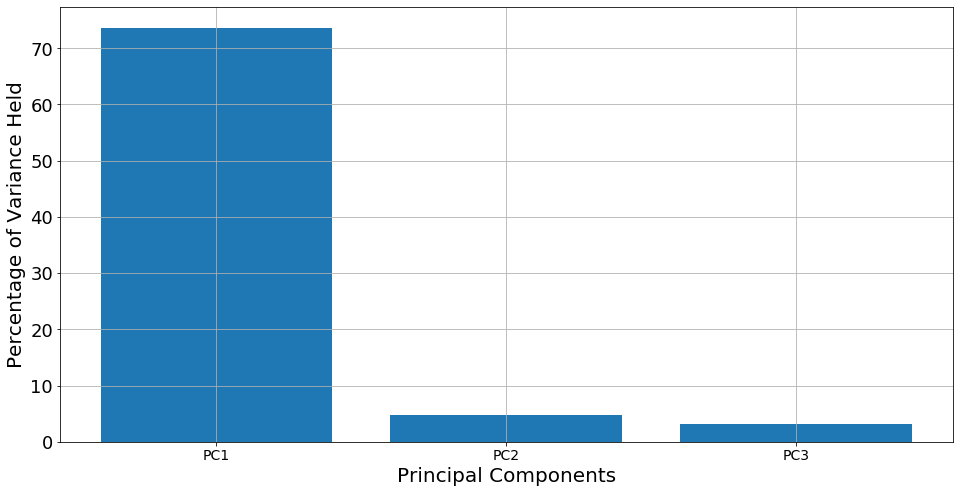

Variation maintained: 81.74
                  
Filtered Features
--------------------
27
305
--------------------
Reduced Features
--------------------
27
3


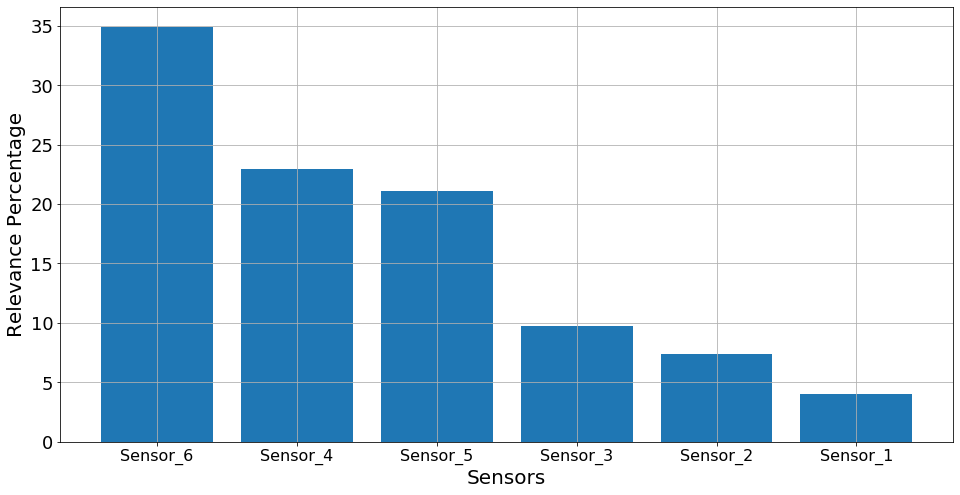

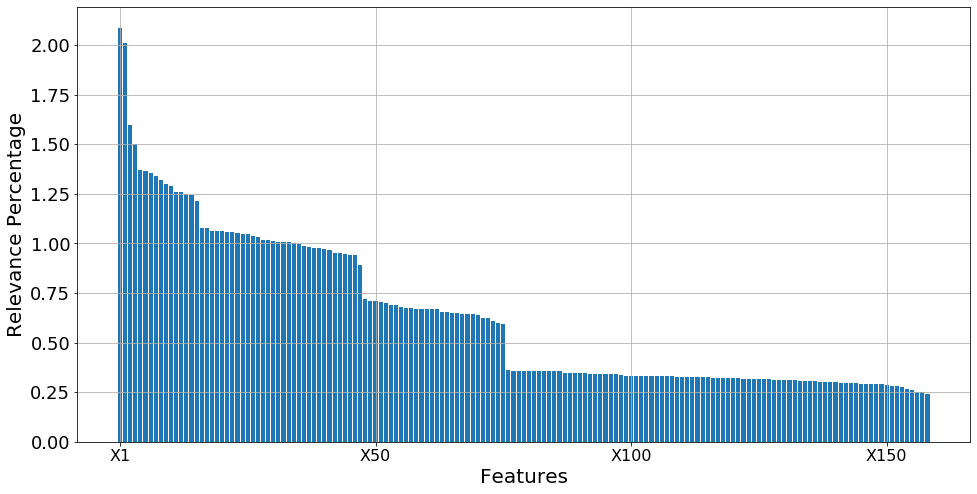

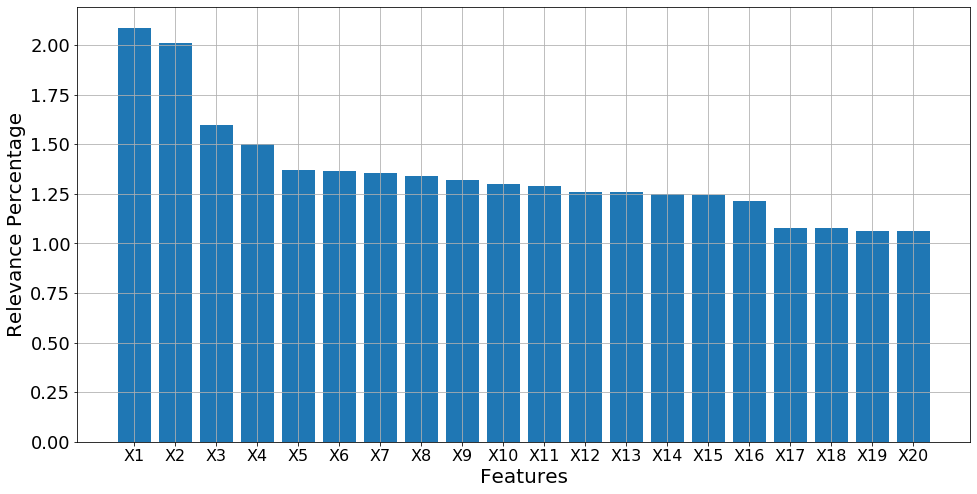

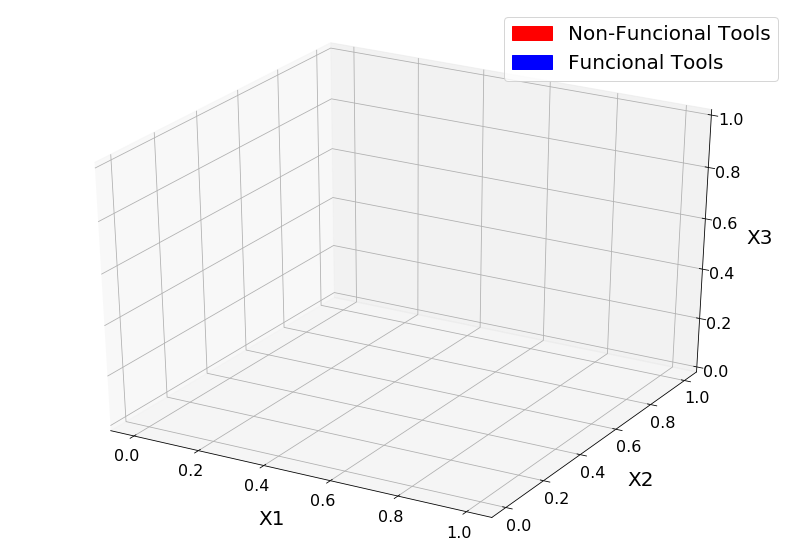

In [60]:
ReducedFeatures = PCA_calc(SelectedFeatures,3,'Analytics') # (Feautures selecionadas, numero de PC's a manter)
                                                          #('Test','Calc','Specific', 'Analytics')

In [61]:
SODA_parameters, processing_parameters = SODA(ReducedFeatures,1,9,0.25) # (Features reduzidas, granularidade mínima,
                                                 # granularidade máxima, passo)

In [62]:
ClassificationPar = GroupingAlgorithm(SODA_parameters,60,20, processing_parameters) # (Labels do SODA, Porcentagem de definição,
                                                             # numero de ID's boas, parametros de processamento)
                             

ção: 2.001587 segundos
Media de porcentagem de uso da CPU: 8.26
---------------------------------------------------
SODA_minkowski_label_50_1.75.csv
Numero de DA planes: 2
Numero de grupos de dados bons: 2
Numero de grupos de dados ruins: 0
Numero de DA planes excluido: 0
Perda de representação dos dados: 0.00
Tempo de execução: 2.001481 segundos
Media de porcentagem de uso da CPU: 5.60
---------------------------------------------------
SODA_minkowski_label_50_2.00.csv
Numero de DA planes: 2
Numero de grupos de dados bons: 2
Numero de grupos de dados ruins: 0
Numero de DA planes excluido: 0
Perda de representação dos dados: 0.00
Tempo de execução: 2.001355 segundos
Media de porcentagem de uso da CPU: 8.85
---------------------------------------------------
SODA_minkowski_label_50_2.25.csv
Numero de DA planes: 2
Numero de grupos de dados bons: 2
Numero de grupos de dados ruins: 0
Numero de DA planes excluido: 0
Perda de representação dos dados: 0.00
Tempo de execução: 2.001566 segundos

In [65]:
Classification(ClassificationPar,1,9, 0.25,33) #(Parametros da data-set, numero de vezes a classificar, granularidade)

0
QDA                18.18     0.0
 
*** 50 - chebyshev - 3.50  ***
-------------------------------------
                   Media  Desvio
Nearest Neighbors  18.18     0.0
Linear SVM         18.18     0.0
RBF SVM            27.27     0.0
Gaussian Process   18.18     0.0
Decision Tree      18.18     0.0
Random Forest      18.18     0.0
Neural Net         18.18     0.0
AdaBoost           18.18     0.0
Naive Bayes        18.18     0.0
QDA                18.18     0.0
 
*** 50 - chebyshev - 3.75  ***
-------------------------------------
                   Media  Desvio
Nearest Neighbors  18.18     0.0
Linear SVM         18.18     0.0
RBF SVM            27.27     0.0
Gaussian Process   18.18     0.0
Decision Tree      18.18     0.0
Random Forest      18.18     0.0
Neural Net         18.18     0.0
AdaBoost           18.18     0.0
Naive Bayes        18.18     0.0
QDA                18.18     0.0
 
*** 50 - chebyshev - 4.00  ***
-------------------------------------
                   Media  

In [47]:
ModelPar = Model_Train(ClassificationPar,'euclidean',"Neural Net",2.75) #(Parametros da data-set, distância, Modelo
                                                                        # granularidade)

In [ ]:
Model_Predict(ModelPar)

In [56]:
os.chdir(r'C:\Users\mathe\Documents\GitHub\Lathes_Tool_Project\Model\IPython')